# Instalação e Pré Requisitios

Instalar Google Chrome. _Rodar Manualmente em WSL_

``` bash
wget -q -O - https://dl-ssl.google.com/linux/linux_signing_key.pub | sudo apt-key add -
echo "deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main" | sudo tee /etc/apt/sources.list.d/google-chrome.list
sudo apt update && sudo apt install -y google-chrome-stable
```

Instalar depenências utilizando `-venv`

``` bash
# configura ambiente virtual
python3 -m venv venv

# ativa ambiente virtual
source venv/bin/activate

# instalar dependências 
pip install -r requirements.txt
```


# Image Scapper

In [1]:
%load_ext autoreload
%autoreload 2
# %autoreload 2  reload all modules

In [2]:
from typing import List, Iterator

Utilitário para exibir imagens

In [3]:
from IPython.display import clear_output, HTML

def display_images_grid(images: Iterator[str]):
    clear_output(wait=True)

    display(HTML(
        ''.join([
            f'<img src="{img}" style="max-width: 150px; margin: 5px; display: inline-block;">'
            for img in images
        ])
    ))


Realiza o download das imagens

In [4]:
root:str = "Dataset"
!rm -rf {root}

num_images:int = 200
query_categorias:List[str] = ["Superman", "Batman"]
variations = ["Happy", "Neutral", "Old", "Timeless", "Surprise"] # Quanto a quantidade de imagens não é suficiente.

images: List[str] = []
def on_save(file_path: str):
    images.append(file_path)
    display_images_grid(reversed(images[-8:]))

import web_scapper
for query in query_categorias:
    web_scapper.scrape_images(query, num_images=num_images, main_folder=root, on_save=on_save, variations=variations)

Processando imagem 201 Batman
Processamento de `Batman` concluído com 200 imagens.
Processamento de `Batman` concluído com "Todas" imagens solicitadas.


# Transfer Learning

In [5]:
import os

#if using Theano with GPU
os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

2025-01-03 08:46:02.976166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735904763.163334  361972 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735904763.225740  361972 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 08:46:03.660584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:

train_split, val_split = 0.7, 0.15
categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['Dataset/Batman', 'Dataset/Superman']


In [7]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [8]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [9]:
random.shuffle(data)

In [10]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [11]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]


In [12]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(60, 2)


In [13]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 400 images from 2 categories
train / validation / test split: 280, 60, 60
training data shape:  (280, 224, 224, 3)
training labels shape:  (280, 2)


In [14]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

I0000 00:00:1735904782.323002  361972 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:07:00.0, compute capability: 6.1


In [15]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [16]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [17]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=12,
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10


I0000 00:00:1735904795.423288  369413 service.cc:148] XLA service 0x7feaec045110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735904795.424808  369413 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-01-03 08:46:35.571413: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735904796.330089  369413 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-03 08:46:37.923683: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[12,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_co

 1/24 ━━━━━━━━━━━━━━━━━━━━ 15:35 41s/step - accuracy: 0.5000 - loss: 0.7973

I0000 00:00:1735904833.770523  369413 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5832 - loss: 0.7682

2025-01-03 08:47:17.849053: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-03 08:47:18.674524: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward

24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5865 - loss: 0.7606 - val_accuracy: 0.4833 - val_loss: 1.1752
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.5342 - loss: 1.0012 - val_accuracy: 0.7500 - val_loss: 0.5192
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.7731 - loss: 0.4594 - val_accuracy: 0.7833 - val_loss: 0.4472
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.8199 - loss: 0.4473 - val_accuracy: 0.7833 - val_loss: 0.4342
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.8747 - loss: 0.3714 - val_accuracy: 0.8167 - val_loss: 0.4154
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.8485 - loss: 0.3881 - val_accuracy: 0.8333 - val_loss: 0.4076
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.8322 - loss: 0.3941 - val_accuracy: 0.7333 - val_loss: 0.5227
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.8813 - loss: 0.3182 - val_accuracy: 0.8000 - val_lo

## Salvar e Carregar Modelo

In [18]:
# Método 1: Salvar o modelo completo
model_new.save('modelo_categorias.keras')


In [19]:
from keras.models import load_model

if "model_new" not in locals():
    model_new = load_model('modelo_categorias.keras')


# Teste do Modelo

FileUpload(value=({'name': 'batman-feliz-01.jpg', 'type': 'image/jpeg', 'size': 312213, 'content': <memory at …

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


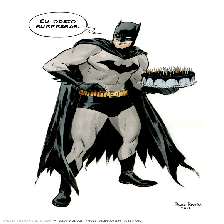

'batman-feliz-01.jpg'

[('Batman', np.float32(0.99990547)), ('Superman', np.float32(9.45082e-05))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


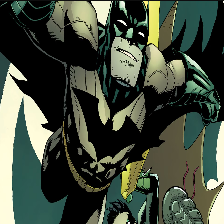

'batman-feliz-02.jpg'

[('Batman', np.float32(1.0)), ('Superman', np.float32(2.0130145e-10))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


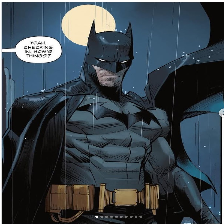

'batman-feliz-03.jpg'

[('Batman', np.float32(1.0)), ('Superman', np.float32(1.3198258e-12))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


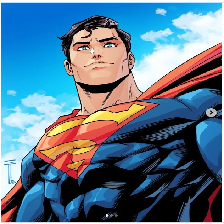

'Superman-feliz-01.jpg'

[('Superman', np.float32(0.8326563)), ('Batman', np.float32(0.16734362))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


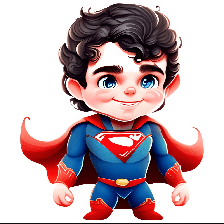

'Superman-feliz-02.jpg'

[('Superman', np.float32(0.9999994)), ('Batman', np.float32(5.45981e-07))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


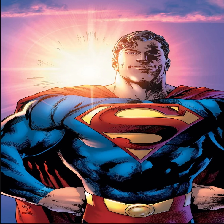

'Superman-feliz-03.jpg'

[('Superman', np.float32(0.9999825)), ('Batman', np.float32(1.752123e-05))]

In [21]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def get_probabilities(probs):
  cat = list(map(lambda x: x.replace(root + "/", ""), categories))

  joined = list(zip(cat, probs))
  joined.sort(key=lambda x: x[1], reverse=True) # sort by the highest probability
  return joined


# Create a file upload widget
upload_widget = widgets.FileUpload(
    accept='image/*',  # Accept all file types
    multiple=True      # Allow only one file at a time
)

display(upload_widget)

def handle_upload(_):
    
    clear_output(wait=True)
    display(upload_widget)

    for up in upload_widget.value:
        uploaded_file = up  
        content = uploaded_file['content']
        name = uploaded_file['name']

        # salvar imagem no diretorio
        with open(name, 'wb') as f:
            f.write(content)


        img, x = get_image(name)
        probabilities = model_new.predict([x])

        display(img, name, get_probabilities(probabilities[0]))


# Attach the handler to the widget
upload_widget.observe(handle_upload)